
为了实现图像拼接程序。我将按照以下步骤进行测试。

1. 提取图片SIFT特征
2. 对两张图片进行特征匹配
3. 对两张图片进行拼接
4. 优化拼接后的结果
5. 合并拼接后的图片



步骤1 ： 提取图像SIFT特征，并且进行显示

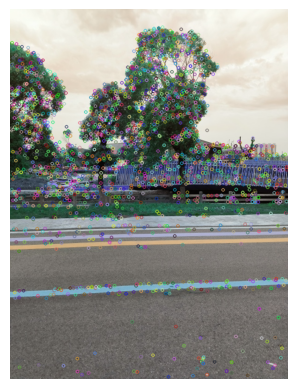

In [56]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def extract_features(img, threshold=0.04):
    # 初始化SIFT检测器
    sift = cv2.SIFT_create(contrastThreshold=threshold)

    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 检测关键点和计算描述符
    keypoints, descriptors = sift.detectAndCompute(img, None)

    return keypoints, descriptors


# Load the image
image = cv2.imread("jpgs/1.jpg")
keypoints,_ = extract_features(image)
# Draw keypoints on the image
cv2.drawKeypoints(image, keypoints, image, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
cv2.imwrite("sift_keypoints.jpg", image)
plt.imshow(image)
plt.axis("off")
plt.show()

步骤2：对两张图片进行特征匹配

In [49]:
import cv2


def match_images(img1, img2):

    # Detect keypoints and compute descriptors for both images
    keypoints1, descriptors1 = extract_features(img1)
    keypoints2, descriptors2 = extract_features(img2)

    # Initialize FLANN matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors using KNN matching
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Apply Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Draw matches
    # matched_img = cv2.drawMatches(
    #     img1,
    #     keypoints1,
    #     img2,
    #     keypoints2,
    #     good_matches,
    #     None,
    #     flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    # )

    return good_matches


# Example usage:
# img1 = cv2.imread("jpgs/1.jpg")
# img2 = cv2.imread("jpgs/2.jpg")
# matched_image = match_images(img1, img2)
# cv2.imwrite("Matched_Image.jpg", matched_image)
# plt.imshow(matched_image)
# plt.axis("off")
# plt.show()

步骤3：对两张图片进行拼接

通过使用之前匹配的关键点对，可以估计两张图片之间的几何变换。具体做法是通过匹配点寻找一个单应性矩阵，用来对齐坐标系。

[[ 1.58538816e+00  7.40829754e-02 -4.22394264e+02]
 [ 3.36773385e-01  1.42565208e+00 -1.31677354e+02]
 [ 9.33514683e-04  7.22706544e-05  1.00000000e+00]]
[[ 6.42058069e-01 -4.67997264e-02  2.65039181e+02]
 [-2.05656417e-01  8.85667426e-01  2.97542528e+01]
 [-5.84507711e-04 -2.03195327e-05  1.00000000e+00]]


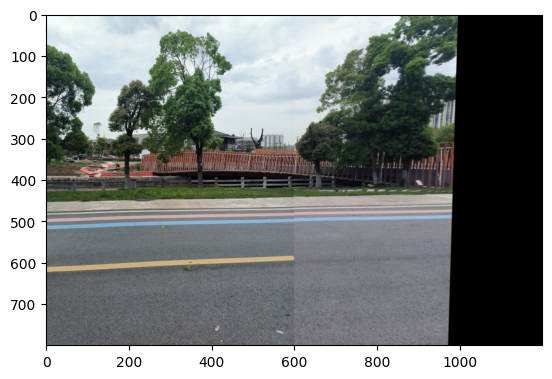

(<matplotlib.image.AxesImage at 0x20eb438f9d0>, None)

In [69]:
import cv2
import numpy as np


def stitch_images(img1,img2):

    # 提取特征点和计算描述符
    sift = cv2.SIFT_create(contrastThreshold=0.04)

    # 检测关键点和计算描述符
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    # 匹配特征点
    matches_all = []
    good_matches = match_images(img1,img2)
    matches_all.append(good_matches)

    # 使用单应性矩阵拼接图片
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    # 计算单应性矩阵
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, maxIters=2000)
    print(M)
    M_inv = np.linalg.inv(M)
    # 归一化矩阵，将每个元素除以最后一个元素
    M_inv /= M_inv[-1, -1]

    print(M_inv)
    # 对img1应用单应性变换
    warpimg = cv2.warpPerspective(
        img2, np.linalg.inv(M), (img1.shape[1] + img2.shape[1], img2.shape[0])
    )
    cv2.imwrite("warpimg.jpg", warpimg)
    warpimg[0:img1.shape[0], 0:img1.shape[1]] = img1
    return warpimg


# 示例用法：

img1 = cv2.imread("jpgs/1.jpg")
img2 = cv2.imread("jpgs/2.jpg")

stitched_image = stitch_images(img1,img2)
stitched_image = cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB)
plt.imshow(stitched_image), plt.show()

步骤四：优化拼接边界。上面的程序直接拼接图像导致边界处割裂比较明显，接下来采用代码进行优化.采用的方法为线性混合，同时去除黑边。

[[ 6.73980554e-01 -3.09658031e-02  2.62202087e+02]
 [-1.98580607e-01  9.10010880e-01  2.68945477e+01]
 [-5.65260637e-04  2.45190121e-05  1.00000000e+00]]

[[ 6.50600371e-01 -3.03616325e-02  2.63148311e+02]
 [-2.15484669e-01  9.08835739e-01  2.76955594e+01]
 [-6.17231741e-04  2.99130065e-05  1.00000000e+00]]


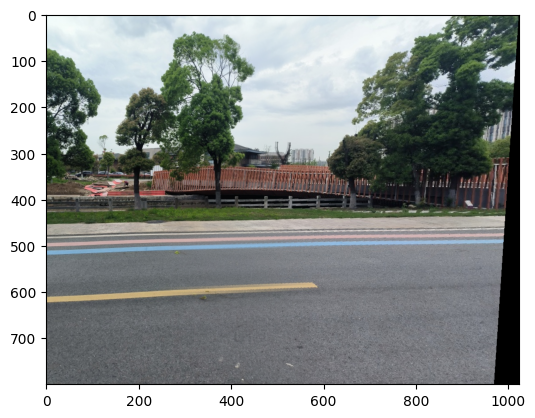

In [89]:
import numpy as np
import cv2

# 图像融合
def warp(img_left, img_right, HomoMat):

    hl, wl = img_left.shape[:2]
    (hr, wr) = img_right.shape[:2]
    stitch_img = np.zeros((max(hl, hr), wl + wr, 3), dtype=np.uint8)

    # 从right img 转换到 left img
    inv_H = np.linalg.inv(HomoMat)
    for i in range(stitch_img.shape[0]):
        for j in range(stitch_img.shape[1]):
            coor = np.array([j, i, 1])
            img_right_coor = inv_H @ coor  
            img_right_coor /= img_right_coor[2]


            y, x = int(round(img_right_coor[0])), int(round(img_right_coor[1]))


            if x < 2 or x >= hr - 2 or y < 2 or y >= wr - 2:
                continue

            stitch_img[i, j] = img_right[x, y]

    stitch_img = linearBlending([img_left, stitch_img])

    # 去除黑边
    stitch_img = removeBlackBorder(stitch_img)

    return stitch_img


def removeBlackBorder(img):

    h, w = img.shape[:2]
    reduced_h, reduced_w = h, w
    # right to left,
    for col in range(w - 1, -1, -1):
        all_black = True
        for i in range(h):
            if np.count_nonzero(img[i, col]) > 0:
                all_black = False
                break
        if all_black == True:
            reduced_w = reduced_w - 1

    # bottom to top ,
    for row in range(h - 1, -1, -1):
        all_black = (True,)
        for i in range(reduced_w):
            if np.count_nonzero(img[row, i]) > 0:
                all_black = (False,)
                break
        if all_black == True:
            reduced_h = reduced_h - 1

    return img[:reduced_h, :reduced_w]


def linearBlending(imgs):

    img_left, img_right = imgs
    (hl, wl) = img_left.shape[:2]
    (hr, wr) = img_right.shape[:2]
    img_left_mask = np.zeros((hr, wr), dtype=np.uint8)
    img_right_mask = np.zeros((hr, wr), dtype=np.uint8)

    # 找到img_left 和 img_right 的mask部分 即非0部分
    for i in range(hl):
        for j in range(wl):
            if np.count_nonzero(img_left[i, j]) > 0:
                img_left_mask[i, j] = 1

    for i in range(hr):
        for j in range(wr):
            if np.count_nonzero(img_right[i, j]) > 0:
                img_right_mask[i, j] = 1

    # 找到两图重合的部分
    overlap_mask = np.zeros((hr, wr), dtype=np.uint8)
    for i in range(hr):
        for j in range(wr):
            if (
                np.count_nonzero(img_left_mask[i, j]) > 0
                and np.count_nonzero(img_right_mask[i, j]) > 0
            ):
                overlap_mask[i, j] = 1

    # 计算重叠区域的线性alph值，即将色彩从 img_left 到 img_right 逐步过度
    alpha_mask = np.zeros((hr, wr)) 
    for i in range(hr):
        minIdx = maxIdx = -1
        for j in range(wr):
            if overlap_mask[i, j] == 1 and minIdx == -1:
                minIdx = j
            if overlap_mask[i, j] == 1:
                maxIdx = j

        if minIdx == maxIdx:  # 融合区域过小
            continue

        decrease_step = 1 / (maxIdx - minIdx)
        for j in range(minIdx, maxIdx + 1):
            alpha_mask[i, j] = 1 - (decrease_step * (j - minIdx))

    linearBlending_img = np.copy(img_right)
    linearBlending_img[:hl, :wl] = np.copy(img_left)
    # 线性混合
    for i in range(hr):
        for j in range(wr):
            if np.count_nonzero(overlap_mask[i, j]) > 0:
                linearBlending_img[i, j] = (
                    alpha_mask[i, j] * img_left[i, j]
                    + (1 - alpha_mask[i, j]) * img_right[i, j]
                )


    return linearBlending_img


if __name__ == "__main__":
    # 读取图像
    img1 = cv2.imread("jpgs/1.jpg")
    img2 = cv2.imread("jpgs/2.jpg")

    # 提取特征点和计算描述符
    sift = cv2.SIFT_create(contrastThreshold=0.04)

    # 检测关键点和计算描述符
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    # 匹配特征点
    good_matches = match_images(img1, img2)

    # 使用单应性矩阵拼接图片
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    # 计算单应性矩阵
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, maxIters=1000)

    M_inv = np.linalg.inv(M)
    # 归一化矩阵，将每个元素除以最后一个元素
    M_inv /= M_inv[-1, -1]

    H = np.linalg.inv(M)
    H /= H[-1,-1]

    print(H)

    stitch_img = warp(img1, img2, H)

    # cv2.imshow("stitch_img", stitch_img)

    cv2.imwrite("out.jpg", stitch_img)

    stitch_img = cv2.cvtColor(stitch_img, cv2.COLOR_BGR2RGB)
    plt.imshow(stitch_img), plt.show()